In [16]:
from Bio import SeqIO
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import re

In [17]:
# User inputs

main_dir = "/home/msdyachkova/data15/bifido/operon_prediction"
tu_path = "/home/msdyachkova/data15/bifido/operon_prediction/tu.txt"
old_anno = "/home/msdyachkova/data15/bifido/operon_prediction/NC_020517.1.gb"
new_anno = "/home/msdyachkova/data15/bifido/b_genomics/reference_genomes/pgap_local/GCF_000220135.1/GCF_000220135_1.gbk"

In [18]:
# 1. Parse genes from GenBank

record = SeqIO.read(new_anno, "genbank")
genes = []
for feature in record.features:
    if feature.type == "gene":
        if "pseudo" in feature.qualifiers:
            pseudo = True
        else:
            pseudo = False
        locus = feature.qualifiers["locus_tag"][0]
        if locus != 'pgap_GCF_000220135.1_001034':
            start = int(feature.location.start) + 1 # feature.location.start returns the 0-based, inclusive starting position
            end = int(feature.location.end)
            strand = feature.location.strand
        else: # New annotation of pgap_GCF_000220135.1_001034 is incorrect, use info from NC_020517.1 annotation
            start = 1206192
            end = 1206434
            strand = 1
            
        genes.append({"locus_tag": locus, "start": start, "end": end, "strand": strand, "pseudo": pseudo})
genes_df = pd.DataFrame(genes).sort_values("start").reset_index(drop=True)

print('genes_df is created successfully:')
display(genes_df)
# genes_df.to_csv("/home/msdyachkova/data15/bifido/operon_prediction/genes_df.tsv", sep="\t")

genes_df is created successfully:


,locus_tag,start,end,strand,pseudo
0,pgap_GCF_000220135.1_000001,1,1467,1,False
1,pgap_GCF_000220135.1_000002,2043,3167,1,False
2,pgap_GCF_000220135.1_000003,3192,4349,1,False
3,pgap_GCF_000220135.1_000004,4346,4816,1,False
4,pgap_GCF_000220135.1_000005,4951,7089,1,False
...,...,...,...,...,...
2084,pgap_GCF_000220135.1_002085,2419863,2420399,-1,False
2085,pgap_GCF_000220135.1_002086,2420522,2421529,-1,False
2086,pgap_GCF_000220135.1_002087,2421529,2421846,-1,False
2087,pgap_GCF_000220135.1_002088,2421850,2422200,-1,False


In [19]:
# Creating tu_expanded correspondence to the new PGAP annotation

genes = {}

record = SeqIO.read(old_anno, "genbank")
for feature in record.features:
    if feature.type == "gene":       
        if "old_locus_tag" in feature.qualifiers:
            locus = feature.qualifiers["old_locus_tag"][0]
        else:
            locus = feature.qualifiers["locus_tag"][0]
        start = int(feature.location.start) + 1 # feature.location.start returns the 0-based, inclusive starting position
        end = int(feature.location.end)
        genes.setdefault((start, end), []).append(locus)

record = SeqIO.read(new_anno, "genbank")
for feature in record.features:
    if feature.type == "gene":
        start = int(feature.location.start) + 1 # feature.location.start returns the 0-based, inclusive starting position
        end = int(feature.location.end)
        locus = feature.qualifiers["locus_tag"][0] 
        genes.setdefault((start, end), []).append(locus)

# Get corresponding locus tags from new PGAP annotation {'old_locus_tag': 'new_locus_tag'}
corr_dict = {}
uniq_dict = {}
for key, value in genes.items():
    if len(value) == 2:
        corr_dict[value[0]] = value[1]
    else:
        uniq_dict[key] = value

# Adding necessary TU correspondence
corr_dict['Bbr_0090'] = 'pgap_GCF_000220135.1_000097'
corr_dict['Bbr_0177'] = 'pgap_GCF_000220135.1_000193'
corr_dict['Bbr_0203'] = 'pgap_GCF_000220135.1_000223'
corr_dict['Bbr_0221'] = 'pgap_GCF_000220135.1_000244'
corr_dict['Bbr_0410'] = 'pgap_GCF_000220135.1_000459'
corr_dict['Bbr_0429'] = 'pgap_GCF_000220135.1_000477'
corr_dict['Bbr_0565'] = 'pgap_GCF_000220135.1_000624'
corr_dict['Bbr_0633'] = 'pgap_GCF_000220135.1_000696'
corr_dict['Bbr_0667'] = 'pgap_GCF_000220135.1_000733'
corr_dict['Bbr_0679'] = 'pgap_GCF_000220135.1_000745'
corr_dict['Bbr_0748'] = 'pgap_GCF_000220135.1_000823'
corr_dict['Bbr_0817'] = 'pgap_GCF_000220135.1_000901'
corr_dict['Bbr_0946'] = 'pgap_GCF_000220135.1_001034'
corr_dict['Bbr_1004'] = 'pgap_GCF_000220135.1_001092'
corr_dict['Bbr_1266'] = 'pgap_GCF_000220135.1_001372'
corr_dict['Bbr_1568'] = 'pgap_GCF_000220135.1_001697'

print('corr_dict is created successfully!')
# pprint.pp(corr_dict)

corr_dict is created successfully!


In [20]:
print(corr_dict['Bbr_1874'])

pgap_GCF_000220135.1_002036


In [ ]:
# Since pseudogenes affect intragenic distance and other characteristics:

In [21]:
def expand_range(unit, pattern, format_func):
    """Helper function to handle range expansion for different patterns."""
    match = pattern.match(unit)
    if not match:
        return False
    
    prefix, rng_part = match.groups() # groups() returns all the (groups) from re expression (e.g., in r'^(Bbr_rRNA16S)(\d+-\d+)$' groups are: Bbr_rRNA16S and \d+-\d+)
    try:
        start_str, end_str = rng_part.split('-', 1)
    except ValueError:
        return False  # Invalid range format

    if int(start_str[-len(end_str):]) < int(end_str):
        full_end_str = start_str[:len(start_str)-len(end_str)] + end_str
    else:
        pref_start_str = start_str[:len(start_str)-len(end_str)]
        full_end_str = str(int(pref_start_str) + 1) + end_str
    
    try:
        start = int(start_str)
        end = int(full_end_str)
    except ValueError:
        return False  # Non-integer value
        
    # Generate all values in the range
    operon_units = []
    u_strands = [] # list of strands of all the units in the operon
    for i in range(start, end + 1):
        # locus = format_func(prefix, i)
        locus = corr_dict[format_func(prefix, i)]
        tu_expanded.append(locus)
        operon_units.append(locus)
        u_strand = genes_df.set_index("locus_tag").at[locus, "strand"]
        u_strands.append(u_strand)
        # print(start, end, locus, u_strand, operon_units, u_strands)
    
    operon_strand = set(u_strands)
    # print(start, end, operon_strand, operon_units, u_strands)
    if operon_strand == {1}:
        operonic_to_up.extend(operon_units[1:])
    elif operon_strand == {-1}:
        operonic_to_up.extend(operon_units[:-1])
    else:
        print("Units in operon are on opposite strands:", operon_units, u_strands)
    
    return True

# 2. Expand transcription units to unit_genes

with open(tu_path, 'r') as file:
    transcription_units = [line.strip() for line in file]

tu_expanded = [] # expanded list of transcription units
operonic_to_up = [] # genes which form operonic pairs to their immediate upstream neighbors

# Define processing patterns and their formatters
RANGE_PATTERNS = [
    (re.compile(r'^(Bbr_rRNA16S)(\d+-\d+)$'), lambda p, i: f"{p}{i}"),
    (re.compile(r'^(Bbr_TRNA)(\d+-\d+)$'),    lambda p, i: f"{p}{i}"),
    (re.compile(r'^(Bbr_)(\d+-\d+)$'),        lambda p, i: f"{p}{i:04d}"),
]

for unit in transcription_units:
    if "-" in unit:
        handled = False
        # Try all known patterns
        for pattern, formatter in RANGE_PATTERNS:
            if expand_range(unit, pattern, formatter):
                handled = True
                break
        
        if not handled:
            # Fallback for unexpected formats
            tu_expanded.append(corr_dict[unit])
    else:
        tu_expanded.append(corr_dict[unit])

print('tu_expanded is created successfully!', len(tu_expanded))
# print(tu_expanded)
print('operonic_to_up is created successfully!', len(operonic_to_up))
# print(operonic_to_up)

tu_expanded is created successfully! 832
operonic_to_up is created successfully! 414


In [22]:
# Restricting tu_expanded and operonic_to_up by CDS only

tu_expanded_cds = []
operonic_to_up_cds = []

record = SeqIO.read(new_anno, "genbank")
for feature in record.features:
    if feature.type == "CDS":
        locus = feature.qualifiers["locus_tag"][0]
        if locus in tu_expanded and locus != 'pgap_GCF_000220135.1_000031': # 'pgap_GCF_000220135.1_000031' is in Phylogenetically_Misplaced_Genes
            tu_expanded_cds.append(locus)

        if locus in operonic_to_up and locus != 'pgap_GCF_000220135.1_000031':
            operonic_to_up_cds.append(locus)
        
print(len(tu_expanded_cds))
print(len(operonic_to_up_cds))

780
400


In [23]:
# 3. Create a dict of immediate upstream neighbors (IUNs)
# (only directonic genes; ignore genes that are not TUs)

n_genes = len(genes_df)
iun_dict = {}

for idx, row in genes_df.iterrows():
    locus = row["locus_tag"] 
    if (idx == 0 or idx == n_genes - 1 # Since the first and the last genes are on the opposite strands we dont add them to the dict;
                 or locus not in tu_expanded): # We add only genes with transcription info
                 # or locus not in tu_expanded_cds):
        continue

    strand = row["strand"]

    neighbor_idx = idx - 1 if strand == 1 else idx + 1
    neighbor_row = genes_df.iloc[neighbor_idx]
    n_locus = neighbor_row["locus_tag"]
    n_strand = neighbor_row["strand"]

    if not neighbor_row["pseudo"] and strand == n_strand and n_locus != 'pgap_GCF_000220135.1_000031': # We check only neighbors since transcribed units cannot be pseudogenes; also, 'pgap_GCF_000220135.1_000031' is in Phylogenetically_Misplaced_Genes
        iun_dict[locus] = n_locus

print('iun_dict is created seccessfully!', len(iun_dict))
# print(len(iun_dict), iun_dict)

iun_dict is created seccessfully! 581


In [32]:
print(iun_dict["pgap_GCF_000220135.1_001743"])

pgap_GCF_000220135.1_001744


In [161]:
# 4. Create input df and compute features for further ML

dist_data = []  # store tuples of (locus_tag, distance, label, same_strand)

for key, value in iun_dict.items():
    row = genes_df.set_index("locus_tag").loc[key]
    neighbor_row = genes_df.set_index("locus_tag").loc[value]
    
    locus = key
    strand = row["strand"] # same as neighbor_row["strand"] since genes in iun_dict are directonic genes
    
    dist = row["start"] - neighbor_row["end"] - 1 if strand == 1 else neighbor_row["start"] - row["end"] - 1 
    label = 1 if locus in operonic_to_up else 0 # 1(True) if gene is operonic to IUN, 0(False) if not
    # label = 1 if locus in operonic_to_up_cds else 0
    # hamming = dist_df.loc[pid_to_hog_dict[key], pid_to_hog_dict[value]]
    
    dist_data.append((locus, dist, label))
    # dist_data.append((locus, dist, label, hamming))

# Create final dataframe
tu_df = pd.DataFrame(dist_data, columns=["Protein ID", "Distance to IUN", "Operonic to IUN"])
print('tu_df is created successfully:')
display(tu_df)
# tu_df.to_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml.tsv", sep="\t")


tu_df is created successfully:


,Protein ID,Distance to IUN,Operonic to IUN
0,pgap_GCF_000220135.1_000002,575,0
1,pgap_GCF_000220135.1_000005,134,0
2,pgap_GCF_000220135.1_000006,174,1
3,pgap_GCF_000220135.1_000007,68,1
4,pgap_GCF_000220135.1_000012,105,0
...,...,...,...
576,pgap_GCF_000220135.1_002084,123,1
577,pgap_GCF_000220135.1_002085,122,1
578,pgap_GCF_000220135.1_002086,-1,1
579,pgap_GCF_000220135.1_002087,3,1


The choice between Jaccard and Hamming similarity metrics for binary vectors depends on whether mutual absences (0-0 pairs) are meaningful in the data:

Jaccard = (Number of positions where at least one vector has a 1) / (Number of shared 1s)
A = [1, 0, 1, 0]  
B = [1, 0, 0, 0]  
Shared 1s = 1, Union of 1s = 2 → Jaccard = 1/2 = 0.5

Hamming Similarity = 1 − (Number of differing bits)/(Total bits)
A = [1, 0, 1, 0]  
B = [1, 0, 0, 0]  
Matches = 3/4 → Hamming Similarity = 0.75

Therefore, in our case it is better to use Hamming distance metric.

In [162]:
# Hamming distance matrix for phylogenetic profiles of B. adolescentis orthogroups

import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Set paths
df_path = "/home/msdyachkova/data15/bifido/b_genomics/reference_genomes/OrthoFinder/Results_May29/Phylogenetic_Hierarchical_Orthogroups/N0.tsv"

# Load and preprocess data
df = pd.read_csv(df_path, sep='\t').drop(['OG', 'Gene Tree Parent Clade'], axis=1).set_index('HOG')

# --- OG representation analysis ---
N0_gene_count_binary = df.fillna(0).astype(bool).astype(int) # converts non-empty cells to '1' and empy cells to '0'
N0_gene_count_binary['Total'] = N0_gene_count_binary.sum(axis=1)
N0_gene_count_binary = N0_gene_count_binary.sort_values(by='Total', ascending=False)

# display(N0_gene_count_binary)
# N0_gene_count_binary.to_csv(os.path.join(main_dir, 'phylo_profiling/N0_gene_count_binary.tsv'), sep='\t')

# Creating jaccard-pdist upper-triangle matrix of distances and converting it to squared matrix of difference
condensed_dist = pdist(N0_gene_count_binary.drop('Total', axis=1), 'hamming') # condensed matrix stores the upper-triangular part of the full distance matrix in a flattened format, excluding the diagonal
condensed_dist_r = np.round(condensed_dist, 3)

# Convert to square matrix and round values
dist_matrix = squareform(condensed_dist_r)

# Changing diaganal values '0' to '1' in distMatrix (we dont want same genome to be closest mate by distance)
np.fill_diagonal(dist_matrix, 1)

# Create labeled DataFrame
dist_df = pd.DataFrame(
    dist_matrix,
    index=N0_gene_count_binary.index,
    columns=N0_gene_count_binary.index)

display(dist_df)
# dist_df.to_csv(os.path.join(main_dir, 'phylo_profiling/hamming.tsv'), sep='\t')

HOG,N0.HOG0001103,N0.HOG0001072,N0.HOG0001074,N0.HOG0001075,N0.HOG0001076,N0.HOG0001077,N0.HOG0001078,N0.HOG0001079,N0.HOG0001080,N0.HOG0001081,...,N0.HOG0003546,N0.HOG0003547,N0.HOG0003548,N0.HOG0003549,N0.HOG0003550,N0.HOG0003551,N0.HOG0003622,N0.HOG0003623,N0.HOG0003624,N0.HOG0003625
HOG,,,,,,,,,,,,,,,,,,,,,
N0.HOG0001103,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957
N0.HOG0001072,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957
N0.HOG0001074,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957
N0.HOG0001075,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957
N0.HOG0001076,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N0.HOG0003551,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,...,0.000,0.000,0.000,0.000,0.000,1.000,0.087,0.087,0.087,0.087
N0.HOG0003622,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,...,0.087,0.087,0.087,0.087,0.087,0.087,1.000,0.000,0.000,0.000
N0.HOG0003623,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,0.957,...,0.087,0.087,0.087,0.087,0.087,0.087,0.000,1.000,0.000,0.000


In [163]:
# Create B. breve UCC2003 PID to HOG dictionary

df_path = os.path.join(main_dir, "phylo_profiling/N0.tsv")
df = pd.read_csv(df_path, sep='\t').drop(['OG', 'Gene Tree Parent Clade'], axis=1).set_index('HOG')

df_exploded = df["GCF_000220135.1"].dropna().str.split(', ').explode()

pid_to_hog_dict = {}
for hog, pid in df_exploded.items():
    pid_to_hog_dict[pid] = hog

print('pid_to_hog_dict is created successfully!', len(pid_to_hog_dict))

pid_to_hog_dict is created successfully! 1911


In [167]:
# Add Hamming distance to the input df

tu_df = pd.read_csv(os.path.join(main_dir, "tu_input_for_ml.tsv"), sep="\t").set_index("Protein ID")
tu_df["Hamming Distance to IUN"] = np.nan

for idx in tu_df.index:
    iun = iun_dict[idx]
    if idx in pid_to_hog_dict and iun in pid_to_hog_dict:
        hamming = dist_df.loc[pid_to_hog_dict[idx], pid_to_hog_dict[iun]]
        tu_df.loc[idx, "Hamming Distance to IUN"] = hamming
    elif idx in pid_to_hog_dict and iun not in pid_to_hog_dict:
        print(f'{iun} (iun) is not CDS!')
    elif idx not in pid_to_hog_dict and iun in pid_to_hog_dict:
        print(f'{idx} (idx) is not CDS!')
    else:
        print(f'{idx} (idx) and {iun} (iun) are not CDS!')
        
display(tu_df)
# tu_df.to_csv(os.path.join(main_dir, "tu_input_for_ml_hamming.tsv"), sep="\t")

pgap_GCF_000220135.1_000014 (idx) and pgap_GCF_000220135.1_000015 (iun) are not CDS!
pgap_GCF_000220135.1_000094 (idx) is not CDS!
pgap_GCF_000220135.1_000100 (idx) is not CDS!
pgap_GCF_000220135.1_000192 (iun) is not CDS!
pgap_GCF_000220135.1_000215 (idx) is not CDS!
pgap_GCF_000220135.1_000216 (idx) and pgap_GCF_000220135.1_000215 (iun) are not CDS!
pgap_GCF_000220135.1_000238 (iun) is not CDS!
pgap_GCF_000220135.1_000260 (idx) is not CDS!
pgap_GCF_000220135.1_000282 (idx) is not CDS!
pgap_GCF_000220135.1_000452 (idx) and pgap_GCF_000220135.1_000453 (iun) are not CDS!
pgap_GCF_000220135.1_000486 (iun) is not CDS!
pgap_GCF_000220135.1_000486 (idx) is not CDS!
pgap_GCF_000220135.1_000612 (idx) is not CDS!
pgap_GCF_000220135.1_000720 (iun) is not CDS!
pgap_GCF_000220135.1_000802 (idx) is not CDS!
pgap_GCF_000220135.1_000850 (iun) is not CDS!
pgap_GCF_000220135.1_000850 (idx) is not CDS!
pgap_GCF_000220135.1_000858 (idx) is not CDS!
pgap_GCF_000220135.1_000859 (idx) and pgap_GCF_00022013

,Unnamed: 0,Distance to IUN,Operonic to IUN,Hamming Distance to IUN
Protein ID,,,,
pgap_GCF_000220135.1_000002,0,575,0,0.043
pgap_GCF_000220135.1_000005,1,134,0,0.043
pgap_GCF_000220135.1_000006,2,174,1,0.043
pgap_GCF_000220135.1_000007,3,68,1,0.043
pgap_GCF_000220135.1_000012,4,105,0,0.478
...,...,...,...,...
pgap_GCF_000220135.1_002084,576,123,1,0.130
pgap_GCF_000220135.1_002085,577,122,1,0.130
pgap_GCF_000220135.1_002086,578,-1,1,0.000


Pearson Correlation: -0.2047
Spearman Correlation: -0.1919


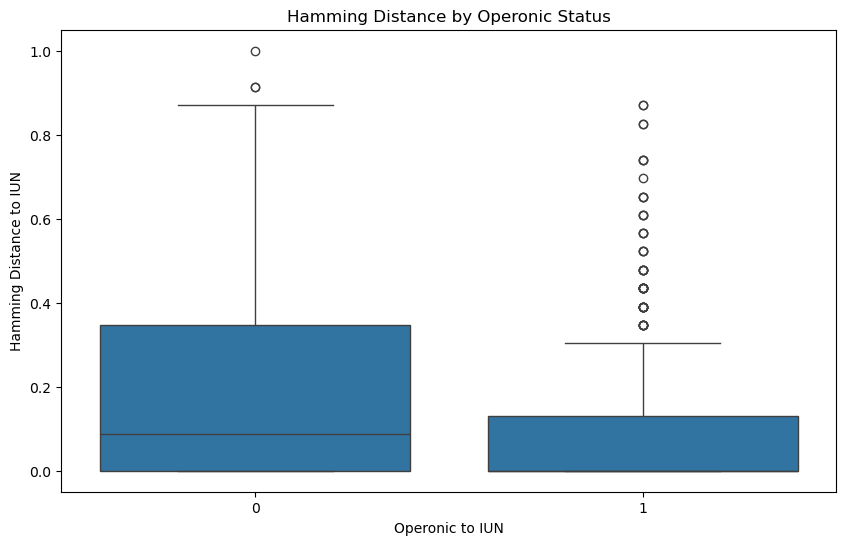

In [168]:
# Correlation between Operonic to IUN and Hamming Distance to IUN

import pandas as pd
import numpy as np

# Assuming your DataFrame is named 'df'
# Extract relevant columns
df_sub = tu_df[['Operonic to IUN', 'Hamming Distance to IUN']].copy()

# Drop rows with NaN values in either column
df_clean = df_sub.dropna()

# Calculate Pearson correlation (measures linear relationship, sensitive to outliers)
pearson_corr = df_clean['Operonic to IUN'].corr(df_clean['Hamming Distance to IUN'])

# Calculate Spearman correlation (rank-based, robust to non-linearity)
spearman_corr = df_clean['Operonic to IUN'].corr(df_clean['Hamming Distance to IUN'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Operonic to IUN', y='Hamming Distance to IUN', data=df_clean)
plt.title('Hamming Distance by Operonic Status')
plt.show()

In [ ]:
# Create go_dict based on GO_process information from annotation

import re
from Bio import SeqIO

# Initialize the dictionary
go_dict = {}

# Parse the GenBank file
record = SeqIO.read(new_anno, "genbank")
for feature in record.features:
    # Check if feature is a CDS and has locus_tag
    if feature.type == "CDS" and "locus_tag" in feature.qualifiers:
        locus_tag = feature.qualifiers["locus_tag"][0]
        
        # Extract the 'note' qualifier if present
        if "note" in feature.qualifiers:
            note = " ".join(feature.qualifiers["note"])  # Combine note lines
            
            # Search for GO_process pattern
            # match = re.search(r"GO_process:\s*(GO:\d+)", note) # when we need the first match only
            match = re.findall(r"GO_process:\s*(GO:\d+)", note)
            if match:
                go_dict[locus_tag] = match
                # go_dict[locus_tag] = ", ".join(match) # store strings, not lists

# Output the resulting dictionary
print(len(go_dict))
# pprint.pp(go_dict)

# tu_df["GO_process"] = None
# tu_df["GO_process"] = tu_df.index.map(go_dict) # .map requires mapper as an argument, whi

743


In [ ]:
ch is function, dict, or Series
# display(tu_df)

# tu_df.to_csv(os.path.join(main_dir, "tu_input_for_ml_go.tsv"), sep="\t")

In [174]:
# Update go_dict with GO terms from InterProScan GO annotation

import re

godag = GODag("/home/msdyachkova/data15/bifido/operon_prediction/semantic_similarity/go-basic.obo", load_obsolete=True)

# Process the table file to extract additional GO terms
table_go_dict = {}

df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/semantic_similarity/GCF_000220135.1/GCF_000220135_1.faa.tsv", sep="\t").iloc[:, [0, 13]]
df.columns = ['locus_tag', 'go_term']
go_anno = df.set_index('locus_tag')
# display(go_anno)

for i, row in go_anno.iterrows():
    if row['go_term'] == '-':  # Check the value in the 'go_term' column
        continue

    go_ids = []
    go_candidates = re.findall(r'GO:\d+', row['go_term'])
    for candidate in go_candidates:
        if godag[candidate].namespace == "biological_process":
            go_ids.append(candidate)
    if not go_ids: # go_ids can be empty since namespace is not always BP
        continue
        
    # Store unique GO terms per locus_tag
    if i not in table_go_dict:
        table_go_dict[i] = set()
    table_go_dict[i].update(go_ids)

# pprint.pp(table_go_dict)

# Update the main go_dict with the table data
for locus_tag, new_go_set in table_go_dict.items():
    if locus_tag in go_dict:
        # Merge existing and new GO terms, removing duplicates
        # existing_go_set = set(go_dict[locus_tag].split(', '))
        existing_go_set = set(go_dict[locus_tag])
        merged_go_set = existing_go_set | new_go_set  # Union of sets
        # go_dict[locus_tag] = ', '.join(sorted(merged_go_set))
        go_dict[locus_tag] = sorted(merged_go_set) # Optional: sort for consistency
    else:
        # go_dict[locus_tag] = ', '.join(sorted(new_go_set))  # Optional: sort
        go_dict[locus_tag] = sorted(new_go_set)

# # Output the resulting dictionary
print(len(go_dict))
# pprint.pp(go_dict)

/home/msdyachkova/data15/bifido/operon_prediction/semantic_similarity/go-basic.obo: fmt(1.2) rel(2025-06-01) 51,747 Terms
1127


In [ ]:
# GOntoSim

# Import libraries

from goatools.base import get_godag
from goatools.godag.reldepth import get_go2reldepth
from goatools.semantic import common_parent_go_ids, semantic_similarity
from goatools.obo_parser import GODag
import sys

# Load Gene Ontology
go = get_godag("go-basic.obo", optional_attrs={'relationship'})

# Define Relationship Semantic Contribution 
is_a = 0.8
part_of = 0.6
regulates = 0.7
negatively_regulates = 0.7
positively_regulates = 0.7
reg = 'reg0.7'

# Helper functions
def all_common_parent_go_ids(goids, godag):
	'''
		This function finds the common ancestors in the GO
		tree of the list of goids in the input.
	'''
	# Find candidates from first
	rec = godag[goids[0]]
	candidates = rec.get_all_upper()
	candidates.update({goids[0]})

	# Find intersection with second to nth goid
	for goid in goids[1:]:
		rec = godag[goid]
		parents = rec.get_all_upper()
		parents.update({goid})

		# Find the intersection with the candidates, and update.
		candidates.intersection_update(parents)
	return candidates

def lowest_common_ancestor(goterms, godag):
	'''
		This function gets the nearest common ancestor
		using the above function.
		Only returns single most specific - assumes unique exists.
	'''
	# Take the element at maximum depth.
	return max(all_common_parent_go_ids(goterms, godag), key=lambda t: godag[t].depth)

def all_paths_to_top(term, godag):
	# inputs: term_id and Go dag with 'relationship' as optional attributes
		""" Returns all possible paths to the root node"""
		if term not in godag:
			sys.stderr.write("Term %s not found!\n" % term)
			return
		def _all_paths_to_top_recursive(rec):
			if rec.level == 0:
				return [[rec]]
			paths = []
			parents = rec.get_goterms_upper()
			for parent in parents:
				top_paths = _all_paths_to_top_recursive(parent)
				for top_path in top_paths:
					top_path.append(rec)
					paths.append(top_path)
			return paths

		go_term = godag[term]
		return _all_paths_to_top_recursive(go_term)

def all_paths_to_top_wang(term, godag, optional_relationships):
	# inputs: term_id and Go dag with 'relationship' as optional attributes
		""" Returns all possible paths to the root node"""
		if term not in godag:
			sys.stderr.write("Term %s not found!\n" % term)
			return
		def _all_paths_to_top_recursive(rec):
			if rec.level == 0:
				return [[rec]]
			paths = []
			parents = rec.get_goterms_upper_rels(optional_relationships)
			#parents = rec.get_goterms_upper()
			for parent in parents:
				#parent = go[parent1]
				top_paths = _all_paths_to_top_recursive(parent)
				for top_path in top_paths:
					top_path.append(rec)
					paths.append(top_path)
			return paths
		go_term = godag[term]
		return _all_paths_to_top_recursive(go_term)

# Downward Graph 				  
def common_children_go_ids(goids, godag):
	'''
		This function finds the common children in the GO
		tree of the list of goids in the input.
	'''
	# Find candidates from first
	rec = godag[goids[0]]
	candidates = rec.get_all_lower()
	candidates.update({goids[0]})
	# Find intersection with second to nth goid
	for goid in goids[1:]:
		rec = godag[goid]
		children = rec.get_all_lower()
		children.update({goid})
		# Find the intersection with the candidates, and update
		candidates.intersection_update(children)
	return candidates

relationships = {'part_of',}
goterms = go.values()
go2reldepth = get_go2reldepth(goterms, relationships)

def highest_common_descendant(goterms, godag):
    '''
    Gets the nearest common descendant using relative depths.
    Only returns single most specific - assumes unique exists.
    '''
    
    # Find common children GO IDs
    common_children = common_children_go_ids(goterms, godag)
    
    if common_children:
        # Find GO ID with minimum relative depth
        return min(common_children, key=lambda go_id: go2reldepth[go_id])
    else:
        return 0

def all_paths_to_bottom(term, godag, x):
		# inputs: term_id and Go dag with 'relationship' as optional attributes
	""" Returns all possible paths to the root node"""
	if term not in godag:
		sys.stderr.write("Term %s not found!\n" % term)
		return

	def _all_paths_to_bottom_recursive(rec):

		if go2reldepth[rec.id] == go2reldepth[term] + x: # if rec.reldepth == godag[term].reldepth+x:
			return [[rec]]
		else:
			paths = []
			children = rec.get_goterms_lower()
			for child in children:
				bottom_paths = _all_paths_to_bottom_recursive(child)
				for bottom_path in bottom_paths:
					bottom_path.append(rec)
					paths.append(bottom_path)
			return paths
	go_term = godag[term]
	return _all_paths_to_bottom_recursive(go_term)

def Downward_Semantic_Value(go_id, go, x):
	''' input: goterm_id 
		returns all of the weighted nodes in path to the Goterm from the children at the xth level below
		#relationship types are global variables with appropriate weights
	'''
	all_all_paths = all_paths_to_bottom(go_id, go, x)
	# print(len(all_all_paths))
	S_values = list()
	for index, path in enumerate(all_all_paths):
		S_values.append([])
		# print("index = " + str(index))
		path.reverse()
		for idx, term in enumerate(path):
			# print (term.item_id)
			if idx == 0:	# which is on idx = 0 
				S_values[index].append((go_id, 1))
			if idx < len(path)-1:
				if term.relationship != {}: 
					# print(term.relationship.keys())
					if 'part_of' in term.relationship:
						if path[idx+1] in term.relationship['part_of']:
							S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * part_of))
						else: 
							S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
					elif 'regulates' in term.relationship:
						if path[idx+1] in term.relationship['regulates']:
							S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * regulates))
						else: 
							S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
					elif 'negatively_regulates' in term.relationship:
						if path[idx+1] in term.relationship['negatively_regulates']:
							S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * negatively_regulates))
						else: 
							S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
					elif 'positively_regulates' in term.relationship:
						if path[idx+1] in term.relationship['positively_regulates']:
							S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * positively_regulates))
						else: 
							S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * is_a))
				else: 
					S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
	return final_values(S_values, 'max')

# Helper functions
def Semantic_Value(go_id, go, method):
	''' input: goterm_id 
		returns all of the weighted (all relatinships in go-basic) paths to root 
		#relationship types are global variables with appropriate weights
	'''
	if method == 'wang':
		# calculates all paths to top (with all relationships)
		optional_relationships = {'part_of'}
		all_all_paths = all_paths_to_top_wang(go_id, go, optional_relationships)
		S_values = list()
		for index, path in enumerate(all_all_paths):
			S_values.append([])
			# print("index = " + str(index))
			path.reverse()
			for idx, term in enumerate(path):
				# Semantic Value of the term itself is always 1 
				if idx == 0:	#which is on idx = 0 
					S_values[index].append((go_id, 1))
				if idx < len(path)-1:
					if term.relationship != {}:
						#print(term.relationship.keys())
						if 'part_of' in term.relationship:
							if path[idx+1] in term.relationship['part_of']:
								S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * part_of))
							else: 
								S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
						else: 
							S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * is_a))
					else: 
						S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
		return final_values(S_values,'max')
	elif method == 'GOGO':
		optional_relationships = {'part_of'}
		all_all_paths = all_paths_to_top_wang(go_id, go, optional_relationships)
		S_values = list()
		for index, path in enumerate(all_all_paths):
			S_values.append([])
			# print("index = " + str(index))
			path.reverse()
			for idx, term in enumerate(path):
				# Semantic Value of the term itself is always 1 
				if idx == 0:	#which is on idx = 0 
					S_values[index].append((go_id, 1))
				if idx < len(path)-1:
					if term.relationship != {}:
						#print(term.relationship.keys())
						if 'part_of' in term.relationship:
							if path[idx+1] in term.relationship['part_of']:
								weight = (1 / (c + len(go[path[idx+1].item_id].children))) + part_of
								S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * weight))
							else: 
								weight = (1 / (c + len(go[path[idx+1].item_id].children))) + is_a
								S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * weight ))
						else: 
							weight = (1 / (c + len(go[path[idx+1].item_id].children))) + is_a
							S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * weight ))
					else: 
						weight = (1 / (c + len(go[path[idx+1].item_id].children))) + is_a
						S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * weight ))
		return final_values(S_values,'max')
	# Baseline Measure - Almost Same as Semantic Value; only Difference is the weight of root as ancestor = 0 and different realtionships
	else:
		all_all_paths = all_paths_to_top(go_id, go)
		S_values = list()
		#print(go_id)
		for index, path in enumerate(all_all_paths):
			S_values.append([])
			# print("index = " + str(index))
			path.reverse()
			for idx, term in enumerate(path):
				# Semantic Value of the term itself is always 1 
				if idx == 0:	#which is on idx = 0 
					S_values[index].append((go_id, 1))
				if idx < len(path)-1 and path[idx+1].item_id != 'GO:0003674' and path[idx+1].item_id != 'GO:0005575' and path[idx+1].item_id != 'GO:0008150':
					if term.relationship != {}: 
						# print(term.relationship.keys())
						if 'part_of' in term.relationship:
							if path[idx+1] in term.relationship['part_of']:
								S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * part_of))
							else: 
								S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
						elif 'regulates' in term.relationship:
							if path[idx+1] in term.relationship['regulates']:
								S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * regulates))
							else: 
								S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
						elif 'negatively_regulates' in term.relationship:
							if path[idx+1] in term.relationship['negatively_regulates']:
								S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * negatively_regulates))
							else: 
								S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
						elif 'positively_regulates' in term.relationship:
							if path[idx+1] in term.relationship['positively_regulates']:
								S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * positively_regulates))
							else: 
								S_values[index].append((path[idx+1].item_id, S_values[index][idx][1] * is_a))
						else: 
							S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
					else: 
						S_values[index].append((path[idx+1].item_id,S_values[index][idx][1] * is_a))
				if (term.item_id == 'GO:0003674' or term.item_id == 'GO:0005575' or term.item_id == 'GO:0008150'):
						S_values[index].append((term.item_id, 0))
		if method == 'Baseline':
			return final_values(S_values, 'max')
		if method == 'Baseline_LCA' :
			svaluesfinal = final_values(S_values, 'max')
			# Replace the max or min s-values in all paths to assign only one value to each node, consistent in all paths
			S_values_Modified = list()
			for index, path in enumerate(S_values):
				S_values_Modified.append([])
				for idx, term1 in enumerate(path):
					# print(list(value for (term, value) in svaluesfinal if term == term1[0]))
					ind = [value for (term, value) in svaluesfinal if term == term1[0]]
					S_values_Modified[index].append((path[idx][0],ind[0]))
			SumOfNodesOnEachPath = list()
			for index, path in enumerate(S_values_Modified):
				# print("Modified index and path: ", index, path)
				SumOfNodesOnEachPath.append(sum(x[1] for x in path))
			maxPath = SumOfNodesOnEachPath.index(max(SumOfNodesOnEachPath))
			return S_values_Modified[maxPath], SumOfNodesOnEachPath[maxPath]

def final_values(S_values, isMax):
	''' Helper function to assign the max of the weights assigned to each term'''
	# S_values = sorted(S_values, key=lambda x: x[0])
	unique_terms_s_values = []
	for path in S_values:
		for term in path:
			unique_terms_s_values.append(term)
	unique_terms_s_values = sorted(unique_terms_s_values, key=lambda x: x[0])
	_s_values = {}
	for y, x in unique_terms_s_values: 
		if y in _s_values: 
			_s_values[y].append((y,x)) 
		else: 
			_s_values[y] = [(y, x)]
	final_s_values = []
	if(isMax == 'max'):
		for node in _s_values:
			final_s_values.append(max(_s_values[node]))
	elif (isMax == 'min'):
		for node in _s_values:
			final_s_values.append(min(_s_values[node]))
	return final_s_values

def intersection(lst1, lst2): 
	''' Helper Function to find intersecting terms from the two input lists of (term, s_Value)'''
	da = {v:k for v, k in lst1}
	db = {v:k for v, k in lst2} 
	return [(da[k],db[k]) for k in da.keys() & db.keys()]

### Calculating Similarity
def Similarity_of_Two_GOTerms(go_id1, go_id2, go, method):
	if method == 'Baseline_LCA':
		lca = lowest_common_ancestor((go_id1, go_id2), go)
		#print(lca)
		sim_lca = Semantic_Value(lca, go, method)
		sim1 = Semantic_Value(go_id1, go, method)
		sim2 = Semantic_Value(go_id2, go, method)
		# sim1[1] and sim2[1] are the sums of all the nodes on the path with the max s-values. 
		sum_sim1_sim2 = (sim1[1] + sim2[1])
		return ((sim_lca[1]*2)/sum_sim1_sim2)
	
	elif method == 'GOntoSim':
		hcd = highest_common_descendant((go_id1, go_id2), go)
		if hcd != 0:
			hcd_depth = go2reldepth[hcd]
			go1_depth = go2reldepth[go_id1]
			go2_depth = go2reldepth[go_id2]
			x = hcd_depth - go1_depth
			y = hcd_depth - go2_depth
			sv_a = Downward_Semantic_Value(go_id1, go, x)
			sv_b = Downward_Semantic_Value(go_id2, go, y)
			intersecting_terms = intersection(sv_a,sv_b)
			numerator = sum([x for t in intersecting_terms for x in t]) # Sum of common terms in all paths wrt to each of the 2 terms
			denominator = sum(x for y, x in sv_a) + sum(x for y, x in sv_b) #(where sv_a has 2 values for each term, second being the SV)
			sim_down = (numerator/denominator)
		else:
			sim_down = 0
		sim_upper = Similarity_of_Two_GOTerms(go_id1,go_id2, go, 'Baseline_LCA')
		sim = (sim_down*0.5) + (sim_upper*0.5)
		#sim = (sim_down*0.3) + (sim_upper*0.7)
		return sim
		
	elif method == 'wang' or method == 'Baseline' or method == 'GOGO':
		sv_a = Semantic_Value(go_id1, go, method)
		sv_b = Semantic_Value(go_id2, go,  method)
		intersecting_terms = intersection(sv_a,sv_b)
		numerator = sum([x for t in intersecting_terms for x in t])
		denominator = sum(x for y, x in sv_a) + sum(x for y, x in sv_b) #(where sv_a has 2 values for each term, second being the SV)
		Similarity = (numerator/denominator)
		return Similarity
	elif method == 'Baseline_Desc':
		hcd = highest_common_descendant((go_id1, go_id2), go)
		if hcd != 0:
			hcd_depth = go2reldepth[hcd]
			go1_depth = go2reldepth[go_id1]
			go2_depth = go2reldepth[go_id2] # go[go_id2].reldepth
			x = hcd_depth - go1_depth
			y = hcd_depth - go2_depth
			sv_a = Downward_Semantic_Value(go_id1, go, x)
			sv_b = Downward_Semantic_Value(go_id2, go, y)
			intersecting_terms = intersection(sv_a,sv_b)
			numerator = sum([x for t in intersecting_terms for x in t]) # Sum of common terms in all paths wrt to each of the 2 terms
			denominator = sum(x for y, x in sv_a) + sum(x for y, x in sv_b) #(where sv_a has 2 values for each term, second being the SV)
			sim_down = (numerator/denominator)
		else:
			sim_down = 0
		sim_upper = Similarity_of_Two_GOTerms(go_id1,go_id2, go, 'Baseline')
		sim = (sim_down*0.5) + (sim_upper*0.5)
		#sim = (sim_down*0.3) + (sim_upper*0.7)
		return sim
	elif method == 'Baseline_Desc_only':
		hcd = highest_common_descendant((go_id1, go_id2), go)
		if hcd != 0:
			hcd_depth = go2reldepth[hcd]
			go1_depth = go2reldepth[go_id1]
			go2_depth = go2reldepth[go_id2]
			x = hcd_depth - go1_depth
			y = hcd_depth - go2_depth
			sv_a = Downward_Semantic_Value(go_id1, go, x)
			sv_b = Downward_Semantic_Value(go_id2, go, y)
			intersecting_terms = intersection(sv_a,sv_b)
			numerator = sum([x for t in intersecting_terms for x in t]) # Sum of common terms in all paths wrt to each of the 2 terms
			denominator = sum(x for y, x in sv_a) + sum(x for y, x in sv_b) #(where sv_a has 2 values for each term, second being the SV)
			sim_down = (numerator/denominator)
		else:
			sim_down = 0
		return sim_down

def Similarity_of_Set_of_GOTerms(set1, set2, method):
	Sim1 = []
	Sim2 = []
	for idx, goterm in enumerate(set1):
		# print ("=========", goterm)
		Sim1.append([])
		for goid in set2:
			#print (goterm , goid)
			Sim1[idx].append((goterm, goid,(Similarity_of_Two_GOTerms(goterm, goid, go, method))))
	for idx, goterm in enumerate(set2):
		Sim2.append([])
		for goid in set1:
			#print (goterm , goid)
			Sim2[idx].append((goterm, goid,(Similarity_of_Two_GOTerms(goterm, goid, go, method))))
	sem1 = []
	sem2 = []

	for index, goterm in enumerate(Sim1):	
		sem1.append((max(Sim1[index], key=lambda x: x[2])))
	for index, goterm in enumerate(Sim2):	
		sem2.append((max(Sim2[index], key=lambda x: x[2])))

	similarity = (sum(x[2] for x in sem1)+ sum(x[2] for x in sem2) )/(len(set1) + len(set2))
	
	return round(similarity, 3)

print('Similarity_of_Two_GOTerms and Similarity_of_Set_of_GOTerms are imported successfully!')

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2025-06-01) 43,448 Terms; optional_attrs(relationship)
Similarity_of_Two_GOTerms and Similarity_of_Set_of_GOTerms are imported successfully!


In [214]:
# Update go_dict with non-obsolete terms

go_dict['pgap_GCF_000220135.1_000135'] = ['GO:0006457', 'GO:0042026']
go_dict['pgap_GCF_000220135.1_000381'] = ['GO:0008152']
go_dict['pgap_GCF_000220135.1_000596'] = ['GO:0006260', 'GO:0006281', 'GO:0006310', 'GO:0009432']
go_dict['pgap_GCF_000220135.1_000697'] = ['GO:0006541', 'GO:0008152']
go_dict['pgap_GCF_000220135.1_000723'] = ['GO:0008299', 'GO:0016114', 'GO:0019288', 'GO:0008152']
go_dict['pgap_GCF_000220135.1_000734'] = ['GO:0006260', 'GO:0006281']
go_dict['pgap_GCF_000220135.1_000851'] = ['GO:0006015', 'GO:0006164', 'GO:0009156', 'GO:0009165', 'GO:0009058']
go_dict['pgap_GCF_000220135.1_000871'] = ['GO:0006457', 'GO:0015031', 'GO:0043335', 'GO:0051083']
go_dict['pgap_GCF_000220135.1_001093'] = ['GO:0006457', 'GO:0009408', 'GO:0042026']
go_dict['pgap_GCF_000220135.1_001220'] = ['GO:0006304', 'GO:0044027']
go_dict['pgap_GCF_000220135.1_001704'] = ['GO:0009234', 'GO:0006744', 'GO:0042371']
go_dict['pgap_GCF_000220135.1_001731'] = ['GO:0043137']

print('go_dict is updated successfully!')

go_dict is updated successfully!


In [ ]:
# Create sim_iun_dict and wang_iun_dict

sim_iun_dict = {}
wang_iun_dict = {}

for tu, iun in iun_dict.items():
    if tu in go_dict and iun in go_dict:
        go_list_tu = go_dict[tu]
        go_list_uin = go_dict[iun]
        
        gontosim = Similarity_of_Set_of_GOTerms(go_list_tu, go_list_uin, 'GOntoSim')
        wangsim = Similarity_of_Set_of_GOTerms(go_list_tu, go_list_uin, 'wang')

        sim_iun_dict[tu] = gontosim
        wang_iun_dict[tu] = wangsim

print('sim_iun_dict is created successfully!', len(sim_iun_dict))
# pprint.pp(sim_iun_dict)
print('wang_iun_dict is created successfully!', len(wang_iun_dict))
# pprint.pp(wang_iun_dict)

In [234]:
# Add GOntoSim and Wang semantic similarity scores to the input ML dataframe

tu_df["GOntoSim Distance to IUN"] = np.nan
tu_df["GOntoSim Distance to IUN"] = tu_df.index.map(sim_iun_dict) # .map requires mapper as an argument, which is function, dict, or Series

tu_df["Wang Distance to IUN"] = np.nan
tu_df["Wang Distance to IUN"] = tu_df.index.map(wang_iun_dict)

# tu_df.rename(columns={
#     "GOntoSim Distance to IUN": "GOntoSim Similarity to IUN",
#     "Wang Distance to IUN": "Wang Similarity to IUN"}, inplace=True)

display(tu_df)
# tu_df.to_csv(os.path.join(main_dir, "tu_input_for_ml_sim.tsv"), sep="\t")

,Unnamed: 0,Distance to IUN,Operonic to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN
Protein ID,,,,,,
pgap_GCF_000220135.1_000002,0,575,0,0.043,0.738,0.735
pgap_GCF_000220135.1_000005,1,134,0,0.043,NaN,NaN
pgap_GCF_000220135.1_000006,2,174,1,0.043,0.845,0.901
pgap_GCF_000220135.1_000007,3,68,1,0.043,NaN,NaN
pgap_GCF_000220135.1_000012,4,105,0,0.478,NaN,NaN
...,...,...,...,...,...,...
pgap_GCF_000220135.1_002084,576,123,1,0.130,NaN,NaN
pgap_GCF_000220135.1_002085,577,122,1,0.130,NaN,NaN
pgap_GCF_000220135.1_002086,578,-1,1,0.000,NaN,NaN


Pearson Correlation: 0.3541
Spearman Correlation: 0.3688


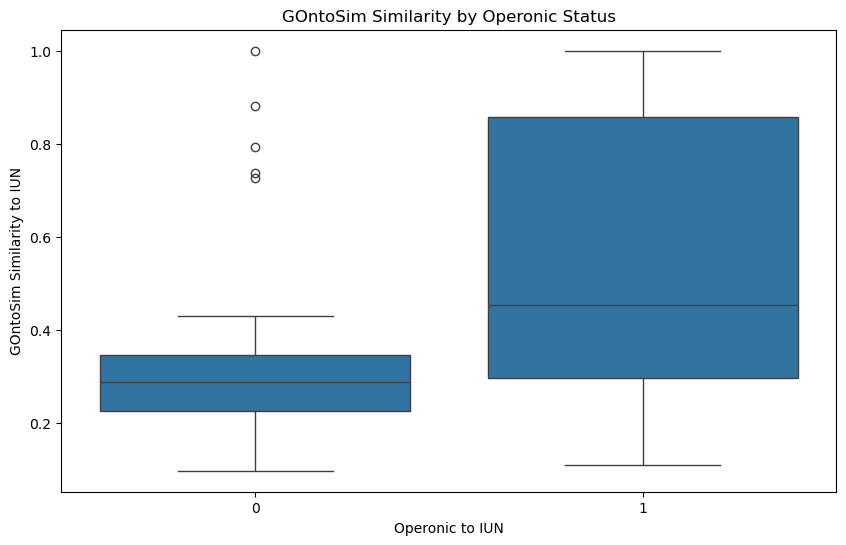

In [235]:
# Correlation between Operonic to IUN and GOntoSim Semantic Similarity to IUN

# Extract relevant columns
df_sub = tu_df[['Operonic to IUN', 'GOntoSim Similarity to IUN']].copy()

# Drop rows with NaN values in either column
df_clean = df_sub.dropna()

# Calculate Pearson correlation (measures linear relationship, sensitive to outliers)
pearson_corr = df_clean['Operonic to IUN'].corr(df_clean['GOntoSim Similarity to IUN'])

# Calculate Spearman correlation (rank-based, robust to non-linearity)
spearman_corr = df_clean['Operonic to IUN'].corr(df_clean['GOntoSim Similarity to IUN'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Operonic to IUN', y='GOntoSim Similarity to IUN', data=df_clean)
plt.title('GOntoSim Similarity by Operonic Status')
plt.show()

Pearson Correlation: 0.3471
Spearman Correlation: 0.3386


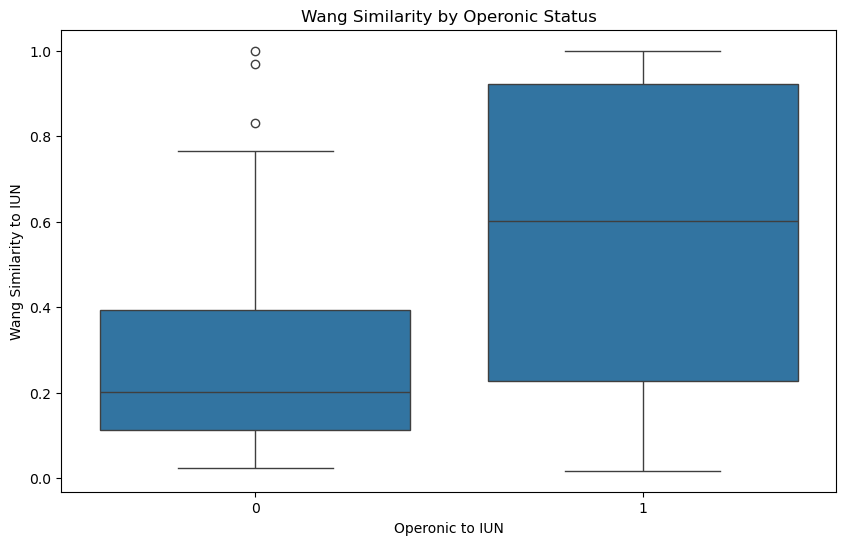

In [236]:
# Correlation between Operonic to IUN and Wang Semantic Similarity to IUN

# Extract relevant columns
df_sub = tu_df[['Operonic to IUN', 'Wang Similarity to IUN']].copy()

# Drop rows with NaN values in either column
df_clean = df_sub.dropna()

# Calculate Pearson correlation (measures linear relationship, sensitive to outliers)
pearson_corr = df_clean['Operonic to IUN'].corr(df_clean['Wang Similarity to IUN'])

# Calculate Spearman correlation (rank-based, robust to non-linearity)
spearman_corr = df_clean['Operonic to IUN'].corr(df_clean['Wang Similarity to IUN'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Operonic to IUN', y='Wang Similarity to IUN', data=df_clean)
plt.title('Wang Similarity by Operonic Status')
plt.show()

Pearson Correlation: -0.2014
Spearman Correlation: -0.2927


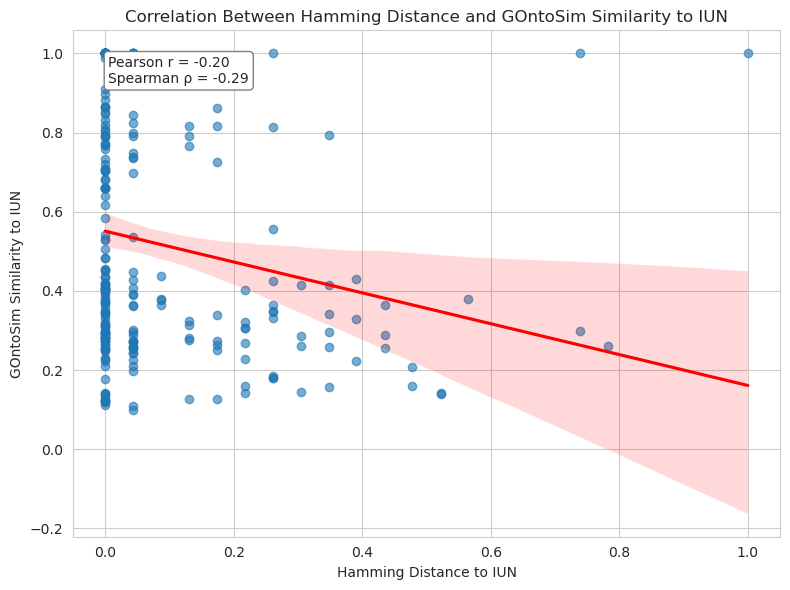

In [240]:
# Correlation between Hamming Distance to IUN and GOntoSim Semantic Similarity to IUN

# Extract relevant columns
df_sub = tu_df[['Hamming Distance to IUN', 'GOntoSim Similarity to IUN']].copy()

# Drop rows with NaN values in either column
df_clean = df_sub.dropna()

# Calculate Pearson correlation (measures linear relationship, sensitive to outliers)
pearson_corr = df_clean['Hamming Distance to IUN'].corr(df_clean['GOntoSim Similarity to IUN'])

# Calculate Spearman correlation (rank-based, robust to non-linearity)
spearman_corr = df_clean['Hamming Distance to IUN'].corr(df_clean['GOntoSim Similarity to IUN'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

# Create plot

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    x='Hamming Distance to IUN',
    y='GOntoSim Similarity to IUN',
    data=df_clean,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'},
    # ci=None  # Disable confidence interval if you want a cleaner line
)

plt.title('Correlation Between Hamming Distance and GOntoSim Similarity to IUN')
plt.xlabel('Hamming Distance to IUN')
plt.ylabel('GOntoSim Similarity to IUN')

# Optional: annotate the correlation coefficients
plt.text(
    0.05, 0.95, 
    f"Pearson r = {pearson_corr:.2f}\nSpearman ρ = {spearman_corr:.2f}", 
    ha='left', va='top', transform=plt.gca().transAxes, fontsize=10, 
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
)

plt.grid(True)
plt.tight_layout()
plt.show()

In [276]:
# Add Upstream Terminator info to the input ML dataframe

import pandas as pd

term_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/terminator_prediction/terminators.tsv", sep=" ").set_index("coordinate")
term_df["3'-coordinate"] = pd.Series(dtype='Int64')
for i, row in term_df.iterrows():
    term_df.loc[i, "3'-coordinate"] = i + len(row["sequence"]) - 1
# display(term_df)

# genes_df = genes_df.set_index("locus_tag")

tu_df["Upstream Terminator"] = pd.Series(dtype='Int64')

start_row = 0

for i, row in tu_df.iterrows():
    strand = genes_df.loc[i, "strand"]
    # print(i, strand)
    if strand == 1:
        c1 = genes_df.loc[iun_dict[i], "end"] + 1
        c2 = genes_df.loc[i, "start"] - 1
    else:
        c1 = genes_df.loc[i, "end"] + 1
        c2 = genes_df.loc[iun_dict[i], "start"] - 1
        
    for j in range(start_row, len(term_df)):
        row = term_df.iloc[j] # term_df.iloc[i] returns a Series where the index labels become the column names, and the row's original index label is stored as the name attribute of the Series
        if row["strand"] == "+":
            term_c1 = row.name + 11 # length of A-rich (11nt) region of terminator
            term_c2 = row["3'-coordinate"] - 14 # max length of spacer (0-2nt) + T-rich(12nt) region of terminator
        else:
            term_c1 = row.name + 14
            term_c2 = row["3'-coordinate"] - 11
        
        if c1 <= term_c1 and term_c2 <= c2:
            print(f'Predicted terminator loop {term_c1}, {term_c2} was found between {c1} and {c2}!')
            tu_df.loc[i, "Upstream Terminator"] = 1
            start_row = j + 1
            break
        else:
            tu_df.loc[i, "Upstream Terminator"] = 0
        # elif c1 <= term_c1 and term_c1 <= c2:
        #     # print(i, strand, f'Only start coordinate ({term_c1}) of rho-independent terminator was found between {c1} and {c2}! End coordinate is: {term_c2} ')
        #     start_row = j + 1
        #     break
        # elif c1 <= term_c2 and term_c2 <= c2:
        #     # print(i, strand, f'Only end coordinate ({term_c2}) of rho-independent terminator was found between {c1} and {c2}! Start coordinate is: {term_c1}')
        #     start_row = j + 1
        #     break

display(tu_df)
# tu_df.to_csv(os.path.join(main_dir, "tu_input_for_ml_term.tsv"), sep="\t")

,program,strand,sequence,free_energy,3'-coordinate
coordinate,,,,,
1466,Both,+,GAGTATGCCTATGGCTTCCTTTACGGGAGCCATTTTTTATATCT,-12.8,1509
10583,Erpin,-,ATATGCGAAACTCCCCTCAGTCCATGAATCGGATTGAGGGGAgTTT...,-13.0,10638
10586,Erpin,+,ACCAACAAAACTCCCCTCAATCCGATTCATGGACTGAGGGGAgTTT...,-13.0,10641
11819,Both,+,AAAAACAACACACCGCCCGAATGAATAGCATCATTCGGGCGGTgTT...,-15.1,11875
12360,Rnamotif,+,GACTGCGGGGCGGCCGGCGTTGGCCcTTATTTCTGTCG,-7.4,12397
...,...,...,...,...,...
2411372,Rnamotif,+,CATCAGCGATGCCAGTGGTTTCGTCATCATTGGTTTTGCAGTACT,-8.2,2411416
2413118,Both,-,CAGATTGCGGTTCGTCAACGGATGTGTTGGCGGgTTTTCGCCTGAA,-9.7,2413163
2416495,Erpin,-,ATATACACAATGGCGCAGTACGAATTCATCCGTACTGCGCCaTTGT...,-13.8,2416549


Predicted terminator loop 1477, 1495 was found between 1468 and 2042!
Predicted terminator loop 20684, 20697 was found between 20669 and 20711!
Predicted terminator loop 50714, 50737 was found between 50593 and 50754!
Predicted terminator loop 129575, 129607 was found between 129511 and 130070!
Predicted terminator loop 134452, 134475 was found between 134376 and 134753!
Predicted terminator loop 135716, 135736 was found between 135696 and 135777!
Predicted terminator loop 152847, 152875 was found between 152811 and 153079!
Predicted terminator loop 188698, 188715 was found between 188609 and 188854!
Predicted terminator loop 258665, 258688 was found between 258595 and 258717!
Predicted terminator loop 262614, 262636 was found between 262545 and 262693!
Predicted terminator loop 265039, 265051 was found between 264993 and 265105!
Predicted terminator loop 276911, 276939 was found between 276886 and 277291!
Predicted terminator loop 359397, 359420 was found between 359339 and 359566!
Pr

,Unnamed: 0,Distance to IUN,Operonic to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator
Protein ID,,,,,,,
pgap_GCF_000220135.1_000002,0,575,0,0.043,0.738,0.735,1
pgap_GCF_000220135.1_000005,1,134,0,0.043,NaN,NaN,0
pgap_GCF_000220135.1_000006,2,174,1,0.043,0.845,0.901,0
pgap_GCF_000220135.1_000007,3,68,1,0.043,NaN,NaN,0
pgap_GCF_000220135.1_000012,4,105,0,0.478,NaN,NaN,0
...,...,...,...,...,...,...,...
pgap_GCF_000220135.1_002084,576,123,1,0.130,NaN,NaN,0
pgap_GCF_000220135.1_002085,577,122,1,0.130,NaN,NaN,0
pgap_GCF_000220135.1_002086,578,-1,1,0.000,NaN,NaN,0


Phi Correlation: -0.4058
Upstream Terminator    0   1
Operonic to IUN             
0                    115  53
1                    400  13


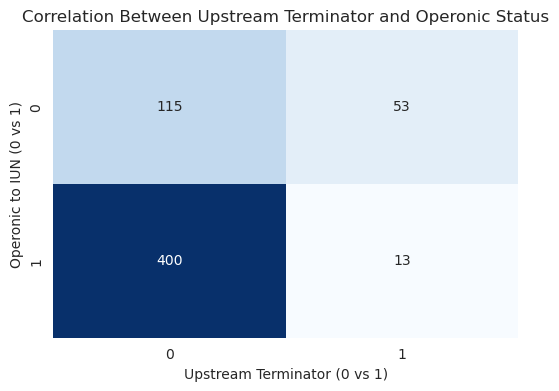

In [280]:
# Calculate the correlation coefficient Phi between operon status and the presence of an upstream terminator
# Phi coefficient and Pearson's correlation are mathematically identical for binary data

# Extract relevant columns
df_sub = tu_df[['Operonic to IUN', 'Upstream Terminator']].copy()

# Calculate Phi correlation
phi = df_sub['Operonic to IUN'].corr(df_sub['Upstream Terminator'])

print(f"Phi Correlation: {phi:.4f}")

# Generate contingency table
contingency_table = pd.crosstab(df_sub['Operonic to IUN'], df_sub['Upstream Terminator'])
print(contingency_table)

plt.figure(figsize=(6, 4))
sns.heatmap(
    contingency_table, 
    annot=True,         # Show numbers in cells
    fmt='d',            # Integer formatting
    cmap='Blues',       # Color scheme
    cbar=False          # Hide color bar (optional)
)

# Add labels and title
plt.xlabel('Upstream Terminator (0 vs 1)')
plt.ylabel('Operonic to IUN (0 vs 1)')
plt.title('Correlation Between Upstream Terminator and Operonic Status')
plt.show()

In [67]:
print(os.getcwd())

/data15/bio/runs-msdyachkova/bifido/operon_prediction


50th percentile of 5'-UTR distribution: 48.0
95th percentile of 5'-UTR distribution: 168.4
99th percentile of 5'-UTR distribution: 231.8


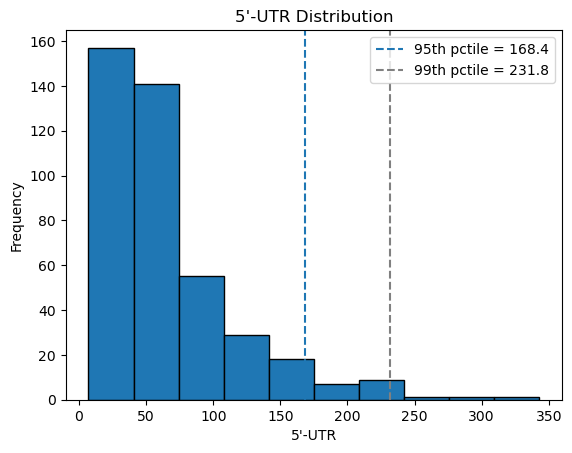

50th percentile of 3'-UTR distribution: 41.0
95th percentile of 3'-UTR distribution: 163.0
99th percentile of 3'-UTR distribution: 414.0


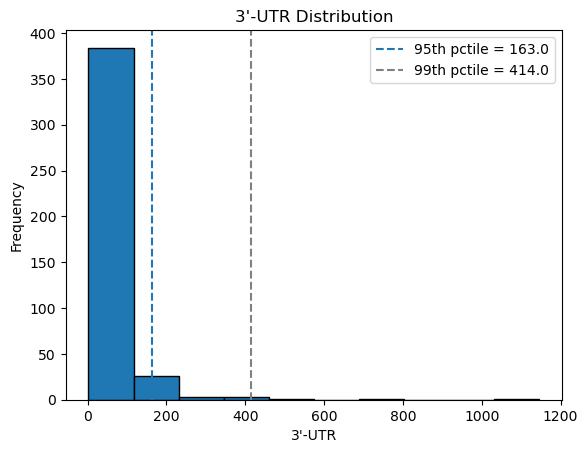

In [25]:
# Distribution of 5'-UTR and 3'-UTR lengths

import pandas as pd
import matplotlib.pyplot as plt

# Replace with your actual DataFrame
df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/utr_distr.tsv", sep="\t")

for col in ["5'-UTR", "3'-UTR"]:
    # Compute the 95th percentile
    p95 = df[col].quantile(0.95)
    p99 = df[col].quantile(0.99)
    print(f'50th percentile of {col} distribution: {df[col].quantile(0.5):.1f}')
    print(f'95th percentile of {col} distribution: {df[col].quantile(0.95):.1f}')
    print(f'99th percentile of {col} distribution: {df[col].quantile(0.99):.1f}')
    
    # Filter out the top 5%
    # filtered = df[col][df[col] <= p95]
    
    # Plot the histogram of the filtered data
    plt.figure()
    # plt.hist(filtered, bins=10, edgecolor='black')
    plt.hist(df[col], bins=10, edgecolor='black')
    plt.axvline(p95, linestyle='--', label=f'95th pctile = {p95:.1f}')
    plt.axvline(p99, linestyle='--', color='grey', label=f'99th pctile = {p99:.1f}')
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [34]:
# Add G4PromFinder promoters info to the input ML dataframe

import pandas as pd

tu_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_term.tsv", sep="\t").drop("Unnamed: 0", axis=1).set_index("Protein ID")
tu_df["Upstream Promoter"] = pd.Series(dtype='Int64')
# display(tu_df)

prom_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/promoter_prediction/Promoter coordinates.txt", sep="\t")
# display(prom_df)

genes_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/genes_df.tsv", sep="\t").drop("Unnamed: 0", axis=1).set_index("locus_tag")
# display(genes_df)

max_5_utr = 168

start_p_row = 0
start_n_row = 601
prom_count = 0
for i in tu_df.index.tolist():
    strand = genes_df.loc[i, "strand"]
    if strand == 1:
        cds_start = genes_df.loc[i, "start"]
        for p in range(start_p_row, 601):
            prom_end = prom_df.loc[p, "End"]
            if cds_start - max_5_utr - 1 <= prom_end and prom_end < cds_start:
                tu_df.loc[i, "Upstream Promoter"] = 1
                prom_count += 1
                start_p_row = p + 1
                break     
    else:
        cds_end = genes_df.loc[i, "end"]
        for n in range(start_n_row, len(prom_df)):
            prom_start = prom_df.loc[n, "Start"]
            if cds_end < prom_start and prom_start <= cds_end + max_5_utr + 1:
                tu_df.loc[i, "Upstream Promoter"] = 1
                prom_count += 1
                start_n_row = n + 1
                break

tu_df["Upstream Promoter"] = tu_df["Upstream Promoter"].fillna(0)
display(tu_df)
print(prom_count)
tu_df.to_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_prom.tsv", sep="\t")

,Distance to IUN,Operonic to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator,Upstream Promoter
Protein ID,,,,,,,
pgap_GCF_000220135.1_000002,575,0,0.043,0.738,0.735,1,0
pgap_GCF_000220135.1_000005,134,0,0.043,NaN,NaN,0,0
pgap_GCF_000220135.1_000006,174,1,0.043,0.845,0.901,0,0
pgap_GCF_000220135.1_000007,68,1,0.043,NaN,NaN,0,0
pgap_GCF_000220135.1_000012,105,0,0.478,NaN,NaN,0,1
...,...,...,...,...,...,...,...
pgap_GCF_000220135.1_002084,123,1,0.130,NaN,NaN,0,0
pgap_GCF_000220135.1_002085,122,1,0.130,NaN,NaN,0,0
pgap_GCF_000220135.1_002086,-1,1,0.000,NaN,NaN,0,0


26


Phi Correlation: 0.0279
Upstream Promoter    0   1
Operonic to IUN           
0                  162   6
1                  393  20


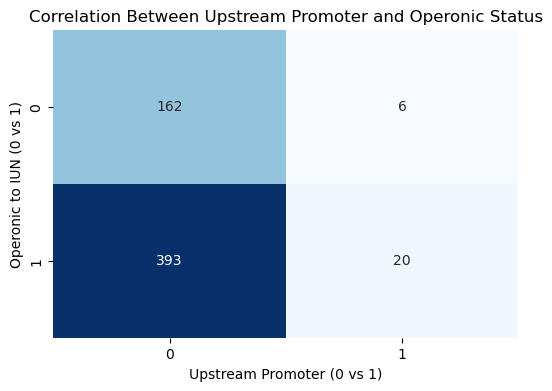

In [36]:
# Calculate the correlation coefficient Phi between operon status and the presence of an upstream promoter
# Phi coefficient and Pearson's correlation are mathematically identical for binary data

import seaborn as sns

# Extract relevant columns
df_sub = tu_df[['Operonic to IUN', 'Upstream Promoter']].copy()

# Calculate Phi correlation
phi = df_sub['Operonic to IUN'].corr(df_sub['Upstream Promoter'])

print(f"Phi Correlation: {phi:.4f}")

# Generate contingency table
contingency_table = pd.crosstab(df_sub['Operonic to IUN'], df_sub['Upstream Promoter'])
print(contingency_table)

plt.figure(figsize=(6, 4))
sns.heatmap(
    contingency_table, 
    annot=True,         # Show numbers in cells
    fmt='d',            # Integer formatting
    cmap='Blues',       # Color scheme
    cbar=False          # Hide color bar (optional)
)

# Add labels and title
plt.xlabel('Upstream Promoter (0 vs 1)')
plt.ylabel('Operonic to IUN (0 vs 1)')
plt.title('Correlation Between Upstream Promoter and Operonic Status')
plt.show()

Due to the revision of the terminator search, it is necessary to add an updated "Upstream Terminator" column based on the 3'-UTR length (95th percentile of 3'-UTR distribution: 163.0):

In [27]:
# Add rho-independent terminators info to the input ML dataframe

import pandas as pd

tu_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_prom.tsv", sep="\t").set_index("Protein ID")
tu_df["Upstream Terminator New"] = pd.Series(dtype='Int64')
# display(tu_df)

genes_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/genes_df.tsv", sep="\t").drop("Unnamed: 0", axis=1).set_index("locus_tag")
# display(genes_df)

term_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/terminator_prediction/terminators.tsv", sep=" ")#.set_index("coordinate")
term_df["3'-coordinate"] = pd.Series(dtype='Int64')
for i in term_df.index.tolist():
    term_df.loc[i, "3'-coordinate"] = term_df.loc[i, "coordinate"] + len(term_df.loc[i, "sequence"]) - 1
# display(term_df)

max_3_utr = 163

start_p_row = 0
start_n_row = 0
term_count = 0
for i in tu_df.index.tolist():
    strand = genes_df.loc[i, "strand"]
    if strand == 1:
        iun_end = genes_df.loc[iun_dict[i], "end"]
        # cds_end = genes_df.loc[i, "end"]
        for p in range(start_p_row, len(term_df)):
            if term_df.loc[p, "strand"] == "+":
                term_start = term_df.loc[p, "coordinate"]
                if iun_end < term_start and term_start <= iun_end + max_3_utr + 1:
                    tu_df.loc[i, "Upstream Terminator New"] = 1
                    term_count += 1
                    start_p_row = p + 1
                    break     
    else:
        # cds_start = genes_df.loc[i, "start"]
        iun_start = genes_df.loc[iun_dict[i], "start"]
        for n in range(start_n_row, len(term_df)):
            if term_df.loc[n, "strand"] == "-":
                term_end = term_df.loc[n, "3'-coordinate"]
                if iun_start - max_3_utr - 1 <= term_end and term_end < iun_start:
                    tu_df.loc[i, "Upstream Terminator New"] = 1
                    term_count += 1
                    start_n_row = n + 1
                    break

tu_df["Upstream Terminator New"] = tu_df["Upstream Terminator New"].fillna(0)
display(tu_df)
print(term_count)
tu_df.to_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_term_new.tsv", sep="\t")

,Distance to IUN,Operonic to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator,Upstream Promoter,Upstream Terminator New
Protein ID,,,,,,,,
pgap_GCF_000220135.1_000002,575,0,0.043,0.738,0.735,1,0,0
pgap_GCF_000220135.1_000005,134,0,0.043,NaN,NaN,0,0,0
pgap_GCF_000220135.1_000006,174,1,0.043,0.845,0.901,0,0,0
pgap_GCF_000220135.1_000007,68,1,0.043,NaN,NaN,0,0,0
pgap_GCF_000220135.1_000012,105,0,0.478,NaN,NaN,0,1,0
...,...,...,...,...,...,...,...,...
pgap_GCF_000220135.1_002084,123,1,0.130,NaN,NaN,0,0,0
pgap_GCF_000220135.1_002085,122,1,0.130,NaN,NaN,0,0,0
pgap_GCF_000220135.1_002086,-1,1,0.000,NaN,NaN,0,0,0


55


In [28]:
print(tu_df["Upstream Terminator"].sum())
print(tu_df["Upstream Terminator New"].sum())

66
55


Since the number of terminators has decreased compared to the previous calculation (which may be due to the presence of intersections between the upper A-rich region of the terminator and the IUN CDS), it is necessary to allow for intersections up to 11 bp (strictly before the hairpin). This should increase the number of predictions compared to the second and first options:

In [46]:
# Add rho-independent terminators info to the input ML dataframe

import pandas as pd

tu_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_term_new2.tsv", sep="\t").set_index("Protein ID")
tu_df["Upstream Terminator Inter"] = pd.Series(dtype='Int64')
# display(tu_df)

genes_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/genes_df.tsv", sep="\t").drop("Unnamed: 0", axis=1).set_index("locus_tag")
# display(genes_df)

term_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/terminator_prediction/terminators.tsv", sep=" ")#.set_index("coordinate")
term_df["3'-coordinate"] = pd.Series(dtype='Int64')
for i in term_df.index.tolist():
    term_df.loc[i, "3'-coordinate"] = term_df.loc[i, "coordinate"] + len(term_df.loc[i, "sequence"]) - 1
# display(term_df)

a_rich = 11
t_rich = 14

start_p_row = 0
start_n_row = 0
term_count = 0
for i in tu_df.index.tolist():
    strand = genes_df.loc[i, "strand"]
    if strand == 1:
        iun_end = genes_df.loc[iun_dict[i], "end"]
        cds_start = genes_df.loc[i, "start"]
        for p in range(start_p_row, len(term_df)):
            if term_df.loc[p, "strand"] == "+":
                term_start = term_df.loc[p, "coordinate"]
                term_end = term_df.loc[p, "3'-coordinate"]
                if iun_end < term_start + a_rich and term_end - t_rich < cds_start:
                    tu_df.loc[i, "Upstream Terminator Inter"] = 1
                    term_count += 1
                    start_p_row = p
                    break     
    else:
        cds_end = genes_df.loc[i, "end"]
        iun_start = genes_df.loc[iun_dict[i], "start"]
        for n in range(start_n_row, len(term_df)):
            if term_df.loc[n, "strand"] == "-":
                term_start = term_df.loc[n, "coordinate"]
                term_end = term_df.loc[n, "3'-coordinate"]
                if cds_end < term_start + t_rich and term_end - a_rich < iun_start:
                    tu_df.loc[i, "Upstream Terminator Inter"] = 1
                    term_count += 1
                    start_n_row = n
                    break

tu_df["Upstream Terminator Inter"] = tu_df["Upstream Terminator Inter"].fillna(0)
display(tu_df)
print(term_count)
# tu_df.to_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_term_inter.tsv", sep="\t")

,Distance to IUN,Operonic to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Terminator,Upstream Promoter,Upstream Terminator New,Upstream Terminator New2,Upstream Terminator Inter
Protein ID,,,,,,,,,,
pgap_GCF_000220135.1_000002,575,0,0.043,0.738,0.735,1,0,0,1,1
pgap_GCF_000220135.1_000005,134,0,0.043,NaN,NaN,0,0,0,0,0
pgap_GCF_000220135.1_000006,174,1,0.043,0.845,0.901,0,0,0,0,0
pgap_GCF_000220135.1_000007,68,1,0.043,NaN,NaN,0,0,0,0,0
pgap_GCF_000220135.1_000012,105,0,0.478,NaN,NaN,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
pgap_GCF_000220135.1_002084,123,1,0.130,NaN,NaN,0,0,0,0,0
pgap_GCF_000220135.1_002085,122,1,0.130,NaN,NaN,0,0,0,0,0
pgap_GCF_000220135.1_002086,-1,1,0.000,NaN,NaN,0,0,0,0,0


52


Thus, we leave for prediction the option of searching for terminators in the intergenic space.

In [52]:
# tu_df = tu_df.drop(["Upstream Terminator", "Upstream Terminator New", "Upstream Terminator New2"], axis=1)
display(tu_df)
tu_df.to_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_term_inter.tsv", sep="\t")

,Distance to IUN,Operonic to IUN,Hamming Distance to IUN,GOntoSim Similarity to IUN,Wang Similarity to IUN,Upstream Promoter,Upstream Terminator Inter
Protein ID,,,,,,,
pgap_GCF_000220135.1_000002,575,0,0.043,0.738,0.735,0,1
pgap_GCF_000220135.1_000005,134,0,0.043,NaN,NaN,0,0
pgap_GCF_000220135.1_000006,174,1,0.043,0.845,0.901,0,0
pgap_GCF_000220135.1_000007,68,1,0.043,NaN,NaN,0,0
pgap_GCF_000220135.1_000012,105,0,0.478,NaN,NaN,1,0
...,...,...,...,...,...,...,...
pgap_GCF_000220135.1_002084,123,1,0.130,NaN,NaN,0,0
pgap_GCF_000220135.1_002085,122,1,0.130,NaN,NaN,0,0
pgap_GCF_000220135.1_002086,-1,1,0.000,NaN,NaN,0,0


Phi Correlation: -0.3852
Upstream Terminator Inter    0   1
Operonic to IUN                   
0                          124  44
1                          405   8


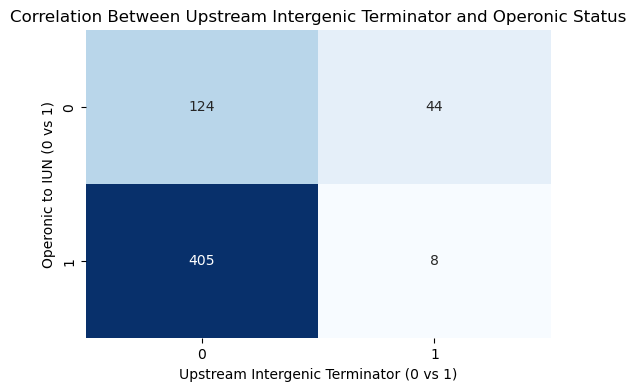

In [54]:
# Calculate the correlation coefficient Phi between operon status and the presence of an upstream terminator
# Phi coefficient and Pearson's correlation are mathematically identical for binary data

import seaborn as sns

# Extract relevant columns
df_sub = tu_df[['Operonic to IUN', 'Upstream Terminator Inter']].copy()

# Calculate Phi correlation
phi = df_sub['Operonic to IUN'].corr(df_sub['Upstream Terminator Inter'])

print(f"Phi Correlation: {phi:.4f}")

# Generate contingency table
contingency_table = pd.crosstab(df_sub['Operonic to IUN'], df_sub['Upstream Terminator Inter'])
print(contingency_table)

plt.figure(figsize=(6, 4))
sns.heatmap(
    contingency_table, 
    annot=True,         # Show numbers in cells
    fmt='d',            # Integer formatting
    cmap='Blues',       # Color scheme
    cbar=False          # Hide color bar (optional)
)

# Add labels and title
plt.xlabel('Upstream Intergenic Terminator (0 vs 1)')
plt.ylabel('Operonic to IUN (0 vs 1)')
plt.title('Correlation Between Upstream Intergenic Terminator and Operonic Status')
plt.show()

I recalculated the intraspecific Hamming distances within the B. breve species. These distances are expected to be very small, but they may improve the model. To do this, I ran Orthofinder in two stages and constructed a phylogenetic tree for B. breve.
Tidied up the N0 output: gnl|extdb|pgap_GCF_000213865_1_001164 -> pgap_GCF_000213865_1_001164.

In [56]:
# Hamming distance matrix for phylogenetic profiles of B. breve orthogroups

import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Set paths
df_path = "/home/msdyachkova/data15/projects/b_breve_genomics/pgap_local/all_faa/OrthoFinder/Results_Aug13/Phylogenetic_Hierarchical_Orthogroups/N0.tsv"

# Load and preprocess data
df = pd.read_csv(df_path, sep='\t').drop(['OG', 'Gene Tree Parent Clade'], axis=1).set_index('HOG')

# --- OG representation analysis ---
N0_gene_count_binary = df.fillna(0).astype(bool).astype(int) # converts non-empty cells to '1' and empy cells to '0'
N0_gene_count_binary['Total'] = N0_gene_count_binary.sum(axis=1)
N0_gene_count_binary = N0_gene_count_binary.sort_values(by='Total', ascending=False)

# display(N0_gene_count_binary)
# N0_gene_count_binary.to_csv(os.path.join(main_dir, 'phylo_profiling/N0_gene_count_binary.tsv'), sep='\t')

# Creating jaccard-pdist upper-triangle matrix of distances and converting it to squared matrix of difference
condensed_dist = pdist(N0_gene_count_binary.drop('Total', axis=1), 'hamming') # condensed matrix stores the upper-triangular part of the full distance matrix in a flattened format, excluding the diagonal
condensed_dist_r = np.round(condensed_dist, 3)

# Convert to square matrix and round values
dist_matrix = squareform(condensed_dist_r)

# Changing diaganal values '0' to '1' in distMatrix (we dont want same genome to be closest mate by distance)
np.fill_diagonal(dist_matrix, 1)

# Create labeled DataFrame
dist_df = pd.DataFrame(
    dist_matrix,
    index=N0_gene_count_binary.index,
    columns=N0_gene_count_binary.index)

display(dist_df)
dist_df.to_csv('/home/msdyachkova/data15/bifido/operon_prediction/phylo_profiling/b_breve/hamming.tsv', sep='\t')

HOG,N0.HOG0001280,N0.HOG0001281,N0.HOG0001282,N0.HOG0001283,N0.HOG0001284,N0.HOG0001285,N0.HOG0001286,N0.HOG0001270,N0.HOG0001271,N0.HOG0001272,...,N0.HOG0003030,N0.HOG0003031,N0.HOG0002946,N0.HOG0002254,N0.HOG0002253,N0.HOG0000044,N0.HOG0000021,N0.HOG0000039,N0.HOG0000040,N0.HOG0002793
HOG,,,,,,,,,,,,,,,,,,,,,
N0.HOG0001280,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982
N0.HOG0001281,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982
N0.HOG0001282,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982
N0.HOG0001283,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982
N0.HOG0001284,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N0.HOG0000044,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,...,0.036,0.036,0.036,0.036,0.036,1.000,0.036,0.036,0.036,0.036
N0.HOG0000021,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,...,0.036,0.036,0.036,0.000,0.000,0.036,1.000,0.036,0.036,0.036
N0.HOG0000039,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,...,0.036,0.036,0.036,0.036,0.036,0.036,0.036,1.000,0.036,0.036


In [60]:
# Create B. breve UCC2003 PID to HOG dictionary

df_path = "/home/msdyachkova/data15/projects/b_breve_genomics/pgap_local/all_faa/OrthoFinder/Results_Aug13/Phylogenetic_Hierarchical_Orthogroups/N0.tsv"
df = pd.read_csv(df_path, sep='\t').drop(['OG', 'Gene Tree Parent Clade'], axis=1).set_index('HOG')

df_exploded = df["GCF_000220135.1"].dropna().str.split(', ').explode()

breve_pid_to_hog_dict = {}
for hog, pid in df_exploded.items():
    breve_pid_to_hog_dict[pid] = hog

print('breve_pid_to_hog_dict is created successfully!', len(breve_pid_to_hog_dict))

breve_pid_to_hog_dict is created successfully! 1924


In [63]:
# Add Hamming distance to the input df

tu_df = pd.read_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_term_inter.tsv", sep="\t").set_index("Protein ID")
tu_df["Hamming Distance to IUN Intra"] = np.nan
# display(tu_df)

for idx in tu_df.index:
    iun = iun_dict[idx]
    if idx in breve_pid_to_hog_dict and iun in breve_pid_to_hog_dict:
        hamming = dist_df.loc[breve_pid_to_hog_dict[idx], breve_pid_to_hog_dict[iun]]
        tu_df.loc[idx, "Hamming Distance to IUN Intra"] = hamming
    elif idx in breve_pid_to_hog_dict and iun not in breve_pid_to_hog_dict:
        print(f'{iun} (iun) is not CDS!')
    elif idx not in breve_pid_to_hog_dict and iun in breve_pid_to_hog_dict:
        print(f'{idx} (idx) is not CDS!')
    else:
        print(f'{idx} (idx) and {iun} (iun) are not CDS!')
        
display(tu_df)
tu_df.to_csv("/home/msdyachkova/data15/bifido/operon_prediction/tu_input_for_ml_hamming_intrasp.tsv", sep="\t")

Calculated the correlation between the updated intraspecific Hamming distances and operonic status:

Pearson Correlation: -0.1103
Spearman Correlation: -0.1071


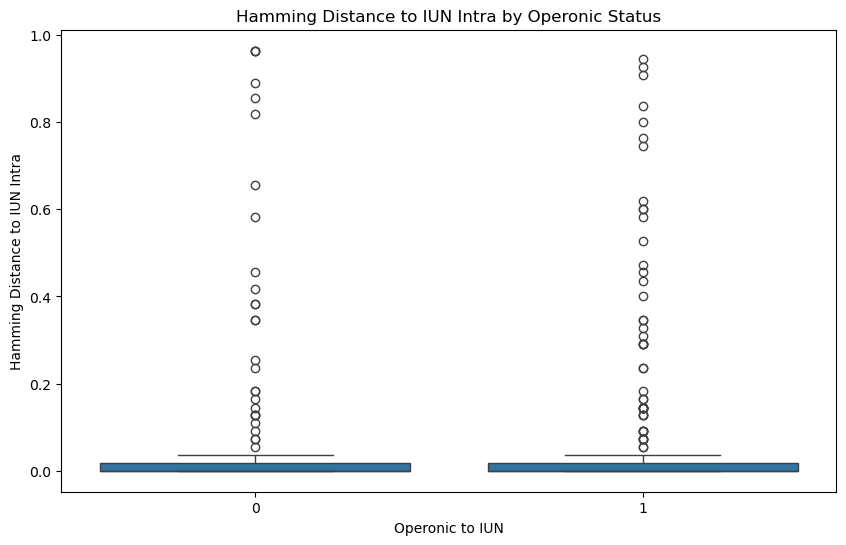

In [64]:
# Correlation between Operonic to IUN and Hamming Distance to IUN Intra

# Extract relevant columns
df_sub = tu_df[['Operonic to IUN', 'Hamming Distance to IUN Intra']].copy()

# Drop rows with NaN values in either column
df_clean = df_sub.dropna()

# Calculate Pearson correlation (measures linear relationship, sensitive to outliers)
pearson_corr = df_clean['Operonic to IUN'].corr(df_clean['Hamming Distance to IUN Intra'])

# Calculate Spearman correlation (rank-based, robust to non-linearity)
spearman_corr = df_clean['Operonic to IUN'].corr(df_clean['Hamming Distance to IUN Intra'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Operonic to IUN', y='Hamming Distance to IUN Intra', data=df_clean)
plt.title('Hamming Distance to IUN Intra by Operonic Status')
plt.show()